# **Librerie e funzioni di base**

In [ ]:
#Librerie utili
import pandas as pd
import numpy as np
from copy import deepcopy

import string
import re

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

#!pip install py_stringsimjoin
#import py_stringsimjoin as ssj
# a commento perchè non funziona
!pip install git+https://github.com/anhaidgroup/py_stringsimjoin
import py_stringmatching as sm
import py_stringsimjoin as ssj
import warnings
warnings.filterwarnings('ignore')
import requests
import networkx as nx

  Cloning https://github.com/anhaidgroup/py_stringsimjoin to /tmp/pip-req-build-e0xut7iy
  Running command git clone --filter=blob:none --quiet https://github.com/anhaidgroup/py_stringsimjoin /tmp/pip-req-build-e0xut7iy
  Resolved https://github.com/anhaidgroup/py_stringsimjoin to commit fb5b9745829a873481687eb2e0e1e2223a7e733a
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for py-stringsimjoin: filename=py_stringsimjoin-0.3.5-cp310-cp310-linux_x86_64.whl size=5282915 sha256=9a830527f5207278989388d412a4365d7eb12101a2ab808f83ff535127507233
  Stored in directory: /tmp/pip-ephem-wheel-cache-zlvcxjyz/wheels/f6/da/a6/cc24da6a2843fa3eec0f2801905be0736899c8caab75c050ef
  Created wheel for py_stringmatching: filename=py_stringmatching-0.4.5-cp310-cp310-linux_x86_64.whl size=2834021 sha256=6a62b33de77702fbf0f3941a2ab810ae20a354158f7e69aab9e06683cb6cb8ed
  Stored i

In [ ]:
################
#funzioni utili#
################
#funzione di conversione da  tabella a matrice
def sim_table(TableA:pd.DataFrame, TableB:pd.DataFrame):
    A = pd.DataFrame({"A": TableA.columns})
    B = pd.DataFrame({"B": TableB.columns})
    S = A.merge(B, how='cross')
    return S


#funzione che crea una sim matrix vuota
def sim_matrix(TableA:pd.DataFrame, TableB:pd.DataFrame):
    S=pd.DataFrame(columns=TableA.columns.tolist(),index=TableB.columns.tolist())
    return S

#creiamo una sim table con valori randomici
def random_sim_table(TableA:pd.DataFrame, TableB:pd.DataFrame):
    S = sim_table(TableA, TableB)
    S["sim"] = np.random.rand(len(S))
    return S

#convertiamo una sim matrix a sim table
def to_sim_table(SimMatrix:pd.DataFrame):
    return SimMatrix.stack().reset_index(name="sim")

#versione con rename e reorder
def to_sim_table_rename(SimMatrix:pd.DataFrame):
    #parametro name per il valore
    #rename per cambiare il nome delle colonne degli indici
    #nelle quadre specifichiamo l'ordine voluto
    return SimMatrix.stack().reset_index(name='sim').rename(columns={'level_0':'B','level_1':'A'})[['A','B','sim']]

#convertiamo una sim table a sim matrix
def to_sim_matrix(SimTable:pd.DataFrame):
    return SimTable.pivot(index="A", columns="B", values="sim") \
              .rename_axis(None, axis=1).rename_axis(None, axis=0)

def prodotto_cartesiano(DA:pd.DataFrame,DB:pd.DataFrame):
    #prendiamo 2 dataframe, aggiungiamo una colonna di 1, con label key, facciamo il merge
    #e droppiamo 'key'
    return DA.assign(key=1).merge(DB.assign(key=1), on="key").drop(columns='key')

#versione che droppa dupplicati
def prodotto_cartesiano_no_dupes(DA:pd.DataFrame,DB:pd.DataFrame):
    return  DA.drop_duplicates().merge(DB.drop_duplicates(), how='cross')

#join esatto
def join_esatto(DA:pd.DataFrame,DB:pd.DataFrame):
    PCC=prodotto_cartesiano_no_dupes(DA,DB)
    return PCC[PCC.AX==PCC.AY].drop_duplicates()
#elementi presenti in una sola tabella dato un join
def solo_in(PCC:pd.DataFrame,Column):
    return PCC.loc[~PCC[Column].isin(INTERSEZIONE[Column])][[Column]].drop_duplicates()

In [ ]:
##################################
#funzioni di string preprocessing#
##################################
def preprocess_s(s):
  # un minimo di Pre-Processing of Labels
      if type(s) is str:
        s = s.lower()
        s = s.replace(',', ' ')
        s = s.replace('&', 'and')
        s = s.replace('_', '')
        s = s.replace('?', '')
        s = s.replace('movie', '') # aggiunta nell'esempio movie
      return s.strip()

def string_preprocess(s:str, char:str=string.punctuation, word:list=[]):
  # una migliore e più completa funzione di Pre-Processing è nella tesina di Mirco Botti
    if type(s) is str:
        s = s.lower()
        for c in char:
            s = s.replace(c, " ")
        for w in word:
            s = s.replace(w, " ")
    else:
        s = str(s)
    s = re.sub(" +", " ", s)
    return s.strip()

In [ ]:
#########################
#Funzioni di valutazione#
#########################

#Confrontiamo i match con il gold standard
def Valuta(Gold:pd.DataFrame, Match:pd.DataFrame):
    Match = Match[['A','B']]
    FOJ = Gold.merge(Match, how='outer', indicator=True)

    TP = FOJ[FOJ['_merge']=='both']
    FP = FOJ[FOJ['_merge']=='right_only']
    FN = FOJ[FOJ['_merge']=='left_only']

    if len(TP) == 0:
        return pd.DataFrame({
                'MT':[len(Match)],
                'TP':[len(TP)],
                'FP':[len(FP)],
                'FN':[len(FN)],
                'P':[round(0,4)],
                'R':[round(0,4)],
                'F':[round(0,4)]
            })
    else:
        P = len(TP)/(len(TP)+len(FP))
        R = len(TP)/(len(TP)+len(FN))
        F = 2 * P * R / ( P + R )
        return pd.DataFrame({
                'MT':[len(Match)],
                'TP':[len(TP)],
                'FP':[len(FP)],
                'FN':[len(FN)],
                'P':[round(P,4)],
                'R':[round(R,4)],
                'F':[round(F,4)]
            })

#chiediamo le metriche di valutazione come FP/TN/TP...
def Vedi_Valuta(Gold:pd.DataFrame, Match:pd.DataFrame, metrics:str):
    Match=Match[['A','B']]
    FOJ=pd.merge(Gold, Match, how='outer', indicator=True)

    TP=FOJ[FOJ['_merge']=='both']
    FP=FOJ[FOJ['_merge']=='right_only']
    FN=FOJ[FOJ['_merge']=='left_only']

    if metrics == 'FP' :
        return FP
    if metrics == 'TP' :
        return TP
    if metrics == 'FN' :
        return FN

# **Funzioni di similarità**

## **Funzioni di similarità label based**

In [ ]:
def levenshtein_sim(row:pd.Series):
    lev = sm.Levenshtein()
    return lev.get_sim_score(
            string_preprocess(row["A"]),
            string_preprocess(row["B"])
        )

def levenshtein_label_based_similarity(TableA:pd.DataFrame, TableB:pd.DataFrame):
    C = sim_table(TableA, TableB)
    C["sim"] = C.apply(levenshtein_sim, axis=1)
    return C.sort_values("sim", ascending=False)

# Jaro
def jaro_sim(row:pd.Series):
    jaro = sm.Jaro()
    return jaro.get_sim_score(
            string_preprocess(row["A"]),
            string_preprocess(row["B"])
        )

def jaro_label_based_similarity(TableA:pd.DataFrame,TableB:pd.DataFrame):
    C = sim_table(TableA, TableB)
    C["sim"] = C.apply(jaro_sim, axis=1)
    return C


# Jaccard
def jaccard_sim(row:pd.Series):
    jac=sm.Jaccard()
    tok = sm.WhitespaceTokenizer(return_set=True)
    return jac.get_sim_score(
            tok.tokenize(string_preprocess(row["A"])),
            tok.tokenize(string_preprocess(row["B"]))
    )

def jaccard_label_based_similarity(TableA:pd.DataFrame, TableB:pd.DataFrame):
    C = sim_table(TableA, TableB)
    C["sim"] = C.apply(jaccard_sim, axis=1)
    return C.sort_values("sim", ascending=False)

# OverlapCoefficient
def OC_sim(row:pd.Series):
    oc = sm.OverlapCoefficient()
    tok = sm.WhitespaceTokenizer(return_set=True)
    return oc.get_sim_score(
            tok.tokenize(string_preprocess(row["A"])),
            tok.tokenize(string_preprocess(row["B"]))
    )

def OC_label_based_similarity(TableA:pd.DataFrame, TableB:pd.DataFrame):
    C = sim_table(TableA, TableB)
    C["sim"] = C.apply(OC_sim, axis=1)
    return C.sort_values("sim", ascending=False)

# JaroWinkler
def JaroWinkler_sim(row:pd.Series):
    jw = sm.JaroWinkler()
    return jw.get_sim_score(
            string_preprocess(row["A"]),
            string_preprocess(row["B"])
        )

def JaroWinkler_label_based_similarity(TableA:pd.DataFrame, TableB:pd.DataFrame):
    C = sim_table(TableA, TableB)
    C["sim"] = C.apply(JaroWinkler_sim, axis=1)
    return C.sort_values("sim", ascending=False)

# MongeElkan
#Secondary similarity function. This is expected to be a sequence-based similarity measure
#(defaults to Jaro-Winkler similarity measure).
def MongeElkan_sim(row:pd.Series):
    me = sm.MongeElkan()
    tok = sm.WhitespaceTokenizer(return_set=True)
    return me.get_raw_score(
            tok.tokenize(string_preprocess(row["A"])),
            tok.tokenize(string_preprocess(row["B"]))
    )


def MongeElkan_label_based_similarity(TableA:pd.DataFrame, TableB:pd.DataFrame):
    C = sim_table(TableA, TableB)
    C["sim"] = C.apply(MongeElkan_sim, axis=1)
    return C.sort_values("sim", ascending=False)

## **Funzioni di similarità Value Overlap**

In [ ]:
#funzioni che controllano se i valori sono sovrapposti
def jaccard_sim_value(row:pd.Series, TableA:pd.DataFrame,TableB:pd.DataFrame):
    j = sm.Jaccard()
    return j.get_raw_score(
            TableA[row["A"]].apply(string_preprocess).tolist(),
            TableB[row["B"]].apply(string_preprocess).tolist()
        )

def jaccard_value_overlap_sim(TableA:pd.DataFrame, TableB:pd.DataFrame):
    C = sim_table(TableA, TableB)
    C["sim"] = C.apply(jaccard_sim_value, args=(TableA, TableB), axis=1)
    return C.sort_values("sim", ascending=False)

def generalized_sim_value(row:pd.Series, TableA:pd.DataFrame, TableB:pd.DataFrame, threshold:float):
    j = sm.GeneralizedJaccard(
            sim_func=sm.Levenshtein().get_sim_score,
            threshold=threshold
        )
    return j.get_raw_score(
            TableA[row["A"]].apply(string_preprocess).tolist(),
            TableB[row["B"]].apply(string_preprocess).tolist()
        )

def generalized_value_overlap_sim(TableA:pd.DataFrame, TableB:pd.DataFrame, threshold:float):
    C = sim_table(TableA, TableB)
    C["sim"] = C.apply(generalized_sim_value, args=(TableA, TableB, threshold), axis=1)
    return C.sort_values("sim", ascending=False)

In [ ]:
#extended Jaccard, non fa il confronto totale
def funzione_similarita_internaLEV(row:pd.Series): # Levenshtein
    lev = sm.Levenshtein()
    return lev.get_sim_score(
            string_preprocess(row["AX"]),
            string_preprocess(row["AY"])
        )

def extended_value_overlap_sim_LEV(row:pd.Series, TableA:pd.DataFrame,TableB:pd.DataFrame, threshold:float):
    TX = TableA[[row["A"]]].applymap(string_preprocess).drop_duplicates()
    TY = TableB[[row["B"]]].applymap(string_preprocess).drop_duplicates()
    TX.columns=['AX']
    TY.columns=['AY']
    PCC = TX.drop_duplicates().merge(TY.drop_duplicates(), how='cross')
    PCC["SimJac"] = PCC.apply(funzione_similarita_internaLEV, axis=1)
    INTERSEZIONE =  PCC[PCC.SimJac>=threshold]
    SoloInAX=PCC.loc[~PCC['AX'].isin(INTERSEZIONE['AX'])][['AX']].drop_duplicates()
    SoloInAY=PCC.loc[~PCC['AY'].isin(INTERSEZIONE['AY'])][['AY']].drop_duplicates()
    return len(INTERSEZIONE)/(len(SoloInAX)+len(SoloInAY)+len(INTERSEZIONE))

def value_overlap_extended_jaccard_LEV(TableA:pd.DataFrame, TableB:pd.DataFrame, threshold:float):
    C = sim_table(TableA, TableB)
    C["sim"] = C.apply(extended_value_overlap_sim_LEV, args=(TableA, TableB, threshold), axis=1)
    return C.sort_values("sim",ascending=False)

def funzione_similarita_internaJaccard(row:pd.Series): # Jaccard
    jac=sm.Jaccard()
    tok = sm.WhitespaceTokenizer(return_set=True)
    return jac.get_sim_score(
            tok.tokenize(string_preprocess(row["AX"])),
            tok.tokenize(string_preprocess(row["AY"])))

def extended_value_overlap_sim_JAC(row:pd.Series, TableA:pd.DataFrame,TableB:pd.DataFrame, threshold:float):
    TX = TableA[[row["A"]]].applymap(string_preprocess).drop_duplicates()
    TY = TableB[[row["B"]]].applymap(string_preprocess).drop_duplicates()
    TX.columns=['AX']
    TY.columns=['AY']
    PCC = TX.drop_duplicates().merge(TY.drop_duplicates(), how='cross')
    PCC["SimJac"] = PCC.apply(funzione_similarita_internaJaccard, axis=1)
    INTERSEZIONE =  PCC[PCC.SimJac>=threshold]
    SoloInAX=PCC.loc[~PCC['AX'].isin(INTERSEZIONE['AX'])][['AX']].drop_duplicates()
    SoloInAY=PCC.loc[~PCC['AY'].isin(INTERSEZIONE['AY'])][['AY']].drop_duplicates()
    return len(INTERSEZIONE)/(len(SoloInAX)+len(SoloInAY)+len(INTERSEZIONE))

def value_overlap_extended_jaccard_JAC(TableA:pd.DataFrame, TableB:pd.DataFrame, threshold:float):
    C = sim_table(TableA, TableB)
    C["sim"] = C.apply(extended_value_overlap_sim_JAC, args=(TableA, TableB, threshold), axis=1)
    return C.sort_values("sim",ascending=False)

In [ ]:
def sim__join(row:pd.Series, TableA:pd.DataFrame,TableB:pd.DataFrame, threshold:float):
    TX = TableA[[row["A"]]].applymap(string_preprocess).drop_duplicates()
    TY = TableB[[row["B"]]].applymap(string_preprocess).drop_duplicates()
    TX.columns=['AX']
    TY.columns=['AY']

    INTERSEZIONE  = ssj.jaccard_join(     TX, TY, # tabelle su cui effettuare il sim join
                                'AX', 'AY', # chiavi delle tabelle
                                'AX', 'AY', # attributi di join
                                  sm.WhitespaceTokenizer(return_set=True),
                                  threshold=threshold,
                                  show_progress=False,
                                  l_out_attrs=['AX'],  r_out_attrs=['AY']
                           )
    SoloInAX=TX.loc[~TX['AX'].isin(INTERSEZIONE['l_AX'])][['AX']].drop_duplicates()
    SoloInAY=TY.loc[~TY['AY'].isin(INTERSEZIONE['r_AY'])][['AY']].drop_duplicates()
    return len(INTERSEZIONE)/(len(SoloInAX)+len(SoloInAY)+len(INTERSEZIONE))


def value_overlap_simjoin_jaccard(TableA:pd.DataFrame, TableB:pd.DataFrame, threshold:float):
    C = sim_table(TableA, TableB)
    C["sim"] = C.apply(sim__join, args=(TableA, TableB, threshold), axis=1)
    return C.sort_values("sim",ascending=False)

# **Combined aproach**

In [ ]:
#approcci combinati per le tabelle di similarità

#LocalMatchingTable = pd.concat([LocalMatchingTable, LocalMatchingTableXY], ignore_index=True, sort=True)
#passiamo una lista di tabelle e ritorno il massimo
def max_sim_table(SimTableList:list):
    ST = pd.DataFrame(columns=["A","B","sim"])
    for x in SimTableList:
        #ST = ST.append(x, ignore_index=True)
        ST = pd.concat([ST, x], ignore_index=True)
    return ST.groupby(["A","B"])["sim"].max().reset_index()

def min_sim_table(SimTableList:list):
    ST = pd.DataFrame(columns=["A","B","sim"])
    for x in SimTableList:
        #ST = ST.append(x, ignore_index=True)
        ST = pd.concat([ST, x], ignore_index=True)
    return ST.groupby(["A","B"])["sim"].min().reset_index()

def avg_sim_table(SimTableList:list):
    ST = pd.DataFrame(columns=["A","B",'sim'])
    for x in SimTableList:
        #ST = ST.append(x, ignore_index=True)
        ST = pd.concat([ST, x], ignore_index=True)
    return ST.groupby(["A","B"])["sim"].mean().reset_index()

In [ ]:
def  Weighted_sum(dataframes, weights):
    if len(dataframes) < 2 or len(dataframes) != len(weights):
        raise ValueError("È necessario fornire almeno due DataFrame e i relativi pesi.")

    result_df = dataframes[0].copy()

    result_df["sim"] = result_df["sim"] * weights[0]

    for i in range(1, len(dataframes)):
        df = dataframes[i]
        weight = weights[i]

        result_df = pd.merge(result_df, df, on=["A", "B"], how="outer")

        result_df["sim"] = result_df.apply(lambda row: row["sim_x"] + row["sim_y"] * weight if not pd.isnull(row["sim_x"]) and not pd.isnull(row["sim_y"]) else row["sim_x"] if not pd.isnull(row["sim_x"]) else row["sim_y"] * weight, axis=1)

        result_df = result_df.drop(columns=["sim_x", "sim_y"])

    return result_df

# **Funzioni generali**

In [ ]:
def to_GMT(MT:pd.DataFrame):
  GMT = pd.DataFrame(columns=['GAT','SOURCE', 'LAT','SLAT'])

  for x in MT.index:
    for y in MT.columns:
      for z in MT.loc[x][y]:
        GMT.loc[len(GMT)]=[x,y,z,str(y)+ '_' + z]
  return GMT

def to_GMM(GMTA:pd.DataFrame):
    df = GMTA.groupby(['GAT','SOURCE'])['LAT'].agg(list).unstack('SOURCE')
    for c in df.columns:
        df.loc[df[c].isnull(), [c]] = df.loc[df[c].isnull(), c].apply(lambda x: [])
    return df

# nuova funzione
def to_GMM(GMTA: pd.DataFrame):
    df = GMTA.groupby(['GAT', 'SOURCE'])['LAT'].agg(list).unstack('SOURCE')

    for c in df.columns:
        df[c] = df[c].apply(lambda x: [] if isinstance(x, float) and np.isnan(x) else x)

    return df

# per generare la Local Attribute Table
def generaLAT(Sources):
  LAT = pd.DataFrame(columns=['SOURCE', 'LAT', 'SLAT'])
  for x in Sources:
    for y in Sources[x].columns:
      LAT.loc[len(LAT)]=[str(x),str(y), str(x)+'_'+str(y)]
  return LAT

In [ ]:
def IsKey(R,K,Numero):
     if Numero:
          return R.groupby(K).size().reset_index(name='counts').query("counts>1").shape[0]
     else:
          return R.groupby(K).size().reset_index(name='counts').query("counts>1")


def IsFD(R,A,Det,Numero):
        if Numero:
            return R.groupby(A)[Det].nunique().reset_index(name='counts').query("counts>1").shape[0]
        else:
            return R.groupby(A)[Det].nunique().reset_index(name='counts').query("counts>1")

def ConfrontaSourceGoldStandard(_GoldStandard, _LAT):

    FOJ= pd.merge(_GoldStandard,_LAT, how='outer', indicator=True).sort_values(['GAT','SOURCE'])

    print("I seguenti LAT non sono mappati in GAT")
    print(FOJ.query(" _merge == 'right_only' ")['SLAT'].tolist())

    print("I seguenti GAT in SOURCE sono mappati in più LAT")
    print(IsFD(_GoldStandard,['GAT','SOURCE'],'LAT',0))

    print("I seguenti LAT in SOURCE sono mappati in più GAT")
    print(IsFD(_GoldStandard,['LAT','SOURCE'],'GAT',0))

# **Local attribute matching**

In [ ]:
#1 attributo alla volta
def thresholding(SimTable:pd.DataFrame, threshold:float):
    return SimTable[SimTable["sim"] > threshold].sort_values(["sim"], ascending=[False])

def top_K(SimTable:pd.DataFrame, K:int, AoB:str="A"):
    MT = deepcopy(SimTable)
    MT["pos"] = MT.sort_values(["sim"], ascending=[False]).groupby(AoB).cumcount()
    return MT[MT["pos"] < K].drop(columns=["pos"]).sort_values([AoB,"sim"], ascending=[True,False])

def top_1(SimTable:pd.DataFrame, AoB:str="A"):
    return top_K(SimTable, 1, AoB)

# **Global mapping**

In [ ]:
#global matching
#useremo queste 2 funzioni all'esame
#troviamo le corrispondenze tra schemi
def stable_marriage(MatchTable:pd.DataFrame):
    MATCH = pd.DataFrame(columns=["A", "B", "sim"])
    MT = deepcopy(MatchTable)
    MT = MT.sort_values(["sim"], ascending=[False])
    while True:
        R = MT.loc[(~MT["A"].isin(MATCH["A"])) & (~MT["B"].isin(MATCH["B"]))]
        if len(R) == 0:
            break
        x = R.iloc[0,:]
        #MATCH = MATCH.append(x, ignore_index=True)
        MATCH = pd.concat([MATCH, x], ignore_index=True)
    return MATCH

def simmetric_best_match(MatchTable:pd.DataFrame):
  CMT = deepcopy(MatchTable)

  CMT['A_RowNo'] = CMT.sort_values(['sim'], ascending=[False]) \
             .groupby(['A']) \
             .cumcount() + 1

  CMT['B_RowNo'] = CMT.sort_values(['sim'], ascending=[False]) \
             .groupby(['B']) \
             .cumcount() + 1

  return CMT[(CMT.A_RowNo==1) & (CMT.B_RowNo==1)].drop(columns=['A_RowNo', 'B_RowNo']).sort_values(['sim'], ascending=[False])

# **Funzioni di Matching**

In [ ]:
def CalcoloLocalMatchingTable(Sources: list):
    LocalMatchingTable = pd.DataFrame(columns=['SOURCE_A', 'LAT_A', 'SOURCE_B', 'LAT_B', 'SLAT_A', 'SLAT_B', 'sim'])

    for x in Sources.keys():
        for y in Sources.keys():
            if (x <= y):  #  x <= y per calcolare anche i matching tra una sorgente e se stessa
                LocalMatchingTableXY = CalcoloMatchingTable(Sources[x], Sources[y])

                print(x,y,len(LocalMatchingTableXY), end=" -- ")
                # si ottiene LocalMatchingTableXY , si rinominano gli attributi
                LocalMatchingTableXY.columns = ['LAT_A', 'LAT_B', 'sim']
                # si aggiungono i 2 nomi delle Local Sources matchate
                LocalMatchingTableXY['SOURCE_A'] = x
                LocalMatchingTableXY['SOURCE_B'] = y
                # e anche i SLAT
                LocalMatchingTableXY['SLAT_A'] = LocalMatchingTableXY['SOURCE_A'] + '_' + LocalMatchingTableXY['LAT_A']
                LocalMatchingTableXY['SLAT_B'] = LocalMatchingTableXY['SOURCE_B'] + '_' + LocalMatchingTableXY['LAT_B']
                # per poi aggiungerlo alla LocalMatchingTable complessiva
                #LocalMatchingTable = LocalMatchingTable.append(LocalMatchingTableXY, sort=True)
                LocalMatchingTable = pd.concat([LocalMatchingTable, LocalMatchingTableXY], ignore_index=True, sort=True)
    return LocalMatchingTable

In [ ]:
# definiamo il calcolo della Matching table
def CalcoloMatchingTable(TableL:pd.DataFrame,TableR:pd.DataFrame):

        SimTableA = levenshtein_label_based_similarity(TableL, TableR)
        SimTableB = jaro_label_based_similarity(TableL, TableR)
        #SimTableB = value_overlap_sim(GlobalSchema, Sources[y])
        SimTableC=value_overlap_simjoin_jaccard(TableL, TableR, 0.8)

        # combiner
        #SimTable = avg_sim_table([SimTableA,SimTableB,SimTableC])
        # SimTable = min_sim_table([SimTableA,SimTableB,SimTableC])
        #SimTable = max_sim_table([SimTableA,SimTableB,SimTableC])

        # Weighted-sum
        SimTable = Weighted_sum([SimTableA,SimTableB,SimTableC], [.3,.3,.45] )


        # dalla tabella di similarità alle corrispondenze

        MatchTable= thresholding(SimTable, 0.65)

        #MatchTable = top_K(SimTable,'A',2)
        MatchTable = top_1(MatchTable,'A')

         # global mapping
        #MatchTable = stable_marriage(MatchTable)
        #MatchTable = simmetric_best_match(MatchTable)

        return MatchTable

# **Clustering**

In [ ]:
def CalcoloDeiCluster(MatchTableCRT):
    CLUSTERS = MatchTableCRT.groupby('A').agg({'B': np.max}).reset_index()
    CLUSTERS.columns=['ClusterElement','ClusterKey']
    CLUSTERS=CLUSTERS[['ClusterKey','ClusterElement']]


    return CLUSTERS.sort_values('ClusterKey')

def fromClusterToGMT(Cluster,LAT):
    GMT=pd.merge(Cluster,LAT, \
      left_on='ClusterElement', right_on='SLAT'). \
       rename(columns={'ClusterKey': 'GAT'}). \
            drop(columns='ClusterElement')
    return GMT.sort_values(['GAT', 'SOURCE'])

In [ ]:
import networkx as nx

def ClusterComponentiConnessi(MatchTable, TuttiInodi):

    MatchTable.columns=['A','B']

    Singleton = set(TuttiInodi) - set(MatchTable['A']).union(set(MatchTable['B']))

    # Creazione del grafo a partire dagli elementi della MatchTable
    G = nx.Graph()
    for _, row in MatchTable.iterrows():
        G.add_edge(row['A'], row['B'])
#        G.add_edge(row['A'], row['B'], weight=row['sim'])
# Aggiungi il peso (etichetta) basato su 'sim'

    # Aggiungi gli elementi singleton all'insieme dei nodi
    for element in Singleton:
        G.add_node(element)

    # Calcola i componenti connessi (clusters)
    clusters = list(nx.connected_components(G))

    # Creazione del DataFrame dei cluster
    cluster_data = {'ClusterKey': [], 'ClusterElement': []}
    for i, cluster in enumerate(clusters):
        for element in cluster:
            cluster_data['ClusterKey'].append(i + 1)
            cluster_data['ClusterElement'].append(element)

    cluster_df = pd.DataFrame(cluster_data)
    return cluster_df

In [ ]:
# La seguente funzione SchemaIntegration contiene tutti i passi per ottenere la GMM a partire da un insieme di Sources
# #   è stato corretto il passo TuttiInodi = [col for df in Sources.values() for col in df.columns]

def SchemaIntegration(Sources):
    #matching  table tra coppie di source
    MatchTable=CalcoloLocalMatchingTable(Sources)[['SLAT_A','SLAT_B']]

    #lista di SLAT come nodi
    TuttiInodi = generaLAT(SOURCES)['SLAT'].tolist()

    #Creiamo dei cluster con i nodi basandoci sulla matchtable
    Cluster=ClusterComponentiConnessi(MatchTable, TuttiInodi)

    LAT = generaLAT(Sources)
    #ricaviamo la global matchtable dai cluster ottenuti
    return to_GMM(fromClusterToGMT(Cluster,LAT))

In [ ]:
#Valutazione del clustering con match indotti tra due tabelle
def MatchIndottiGMT(GMT):
  Join=pd.merge(GMT,GMT, on='GAT')
#  Join=Join[Join.SOURCE_x<=Join.SOURCE_y]
  Join=Join[Join.SLAT_x<Join.SLAT_y]
  Join=Join[['SLAT_x','SLAT_y']]
  Join.columns=['A','B']

  return Join.drop_duplicates()

#**Includes per BabelNet**

In [ ]:
#API_KEY='f0203ed8-c34d-4d5b-a8ba-a26de7a9e63a'
#API_KEY='74af617e-1aec-4415-8807-2c3e1605c802'
API_KEY='ee15e1e1-aa53-4071-9dc9-a95449ecb37d'
#API_KEY='8520739a-7530-4c46-826a-b7ca733dd52a'
languages=['EN','ES','FR']
relation_groups=['HYPONYM','HYPERNYM','MERONYM','HOLONYM']
#forbidden_chars = ['\'','!','_',]
max_number_of_synsets=10 #se non vogliamo limiti, possiamo settarlo a 0
max_number_of_edges=5
alpha=True #filtro per valori alpha numerici
fudge_factor=0.40

In [ ]:
V = nx.Graph()

### **Funzioni per il grafo API e pathFinding**

In [ ]:
# Funzione per creare un edge con nome
def add_edge_with_label(graph, node1, node2, label, weight=None):
    """
    Aggiunge un edge tra due nodi nel grafo con un nome specifico.

    Args:
        graph: Il grafo a cui aggiungere l'edge.
        node1: Il primo nodo dell'edge.
        node2: Il secondo nodo dell'edge.
        label: Il nome da assegnare all'edge.
        weight (opzionale): Il peso dell'edge. Default è None.
    """
    graph.add_edge(node1, node2, label=label, weight=weight)

# Funzione per aggiungere un edge con proprietà
def add_edge_with_properties(graph, node1, node2, properties):
    """
    Aggiunge un edge tra due nodi nel grafo con proprietà specifiche.

    Args:
        graph: Il grafo a cui aggiungere l'edge.
        node1: Il primo nodo dell'edge.
        node2: Il secondo nodo dell'edge.
        properties: Un dizionario contenente le proprietà dell'edge.
    """
    graph.add_edge(node1, node2, **properties)
# Funzione per creare un edge
def add_edge(graph, node1, node2, weight=None):
    """
    Aggiunge un edge tra due nodi nel grafo.

    Args:
        graph: Il grafo a cui aggiungere l'edge.
        node1: Il primo nodo dell'edge.
        node2: Il secondo nodo dell'edge.
        weight (opzionale): Il peso dell'edge. Default è None.
    """
    graph.add_edge(node1, node2, weight=weight)

# Funzione per aggiungere un nodo
def add_node(graph, node):
    """
    Aggiunge un nodo al grafo.

    Args:
        graph: Il grafo a cui aggiungere il nodo.
        node: Il nodo da aggiungere.
    """
    if node not in graph:
        graph.add_node(node)
    ##else:
    ##    print("Il nodo", node, "esiste già nel grafo.")

def add_node_with_properties(graph, node, properties):
    """
    Aggiunge un nodo al grafo con proprietà specifiche.

    Args:
        graph: Il grafo a cui aggiungere il nodo.
        node: Il nodo da aggiungere.
        properties: Un dizionario contenente le proprietà del nodo.
    """
    if node not in graph:
        graph.add_node(node, **properties)
    ##else:
    ##    print("Il nodo", node, "esiste già nel grafo.")



def is_node_present(graph, node):
    """
    Aggiunge un nodo al grafo con proprietà specifiche.

    Args:
        graph: Il grafo a cui aggiungere il nodo.
        node: Il nodo da aggiungere.
        properties: Un dizionario contenente le proprietà del nodo.
    """
    if node not in graph:
        return False
    else:
        return True

def is_lemma_present_with_synsets(graph, node):
    """
    Aggiunge un nodo al grafo con proprietà specifiche.

    Args:
        graph: Il grafo a cui aggiungere il nodo.
        node: Il nodo da aggiungere.
        properties: Un dizionario contenente le proprietà del nodo.
    """
    if node not in graph:
        return False
    else:

        for neighbor in graph.neighbors(node):
        # Controlla se c'è un arco tra il nodo e il suo vicino con l'etichetta desiderata
            if 'label' in graph[node][neighbor] and graph[node][neighbor]['label'] == "HAS":
                return True
    return False

# Aggiunta di edge con proprietà
#add_edge_with_properties(G, 1, 2, {"weight": 0.5, "label": "edge1"})
#add_edge_with_properties(G, 2, 3, {"weight": 0.7, "label": "edge2"})
#add_edge_with_properties(G, 1, 3, {"weight": 0.3, "label": "edge3"})



# Aggiunta di nodi
#G.add_node(1)
#G.add_node(2)
#G.add_node(3)

# Aggiunta di edge con nomi
#add_edge_with_label(G, 1, 2, label="edge1", weight=0.5)
#add_edge_with_label(G, 2, 3, label="edge2", weight=0.7)
#add_edge_with_label(G, 1, 3, label="edge3", weight=0.3)

# Aggiunta di nodi con proprietà
#add_node_with_properties(G, 1, {"color": "red", "size": 10})
#add_node_with_properties(G, 2, {"color": "blue", "size": 15})
#add_node_with_properties(G, 3, {"color": "green", "size": 20})

# Visualizzazione delle proprietà di un nodo
#print("Proprietà del nodo 1:", G.nodes[1])

# Visualizzazione del grafo

**graphbuilding**

In [ ]:
##GRAPH BUILDING
###################################Da testare####################################################
def fetch_synset_ids_for_graph(graph,word,lemma=None,POS=None,language=None):
    # URL dell'API di BabelNet per la ricerca di un termine
    ##################################
    #controllo se word/lemma e synset sono presenti nel grafo

    if lemma is not None:
        if is_lemma_present_with_synsets(graph, lemma):
          return []
    else:
        if is_lemma_present_with_synsets(graph, word):
          return []



    ##################################
    url = f"https://babelnet.io/v9/getSynsetIds"

    # Parametri della richiesta
    params = {
        #'lemma': word,
        #'searchLang': language,  # Lingua italiana
        'key': API_KEY,  # Inserisci la tua chiave API di BabelNet qui
        #'targetLang':target
    }
    if lemma is not None:
       params['lemma']=lemma
    else:
        params['lemma']=word

    if language is not None:
       params['searchLang'] = language
    else:
       params['searchLang'] = languages
    if POS is not None:
       params['POS']=POS
    # Fai la richiesta HTTP
    response = requests.get(url, params=params)
    #response = requests.get(url)
    # Estrai il synset ID dalla risposta JSON
    synset_ids = response.json()
    #print(f"parametri {params}")
    print("risposta dell'API")
    print(response.json())
    if response.status_code != 200:
       synset_ids=[]

    #if synset is not None:
    #   synset_ids = [item for item in synset_ids if item['id'] == synset]
    if len(synset_ids)>max_number_of_synsets:
          #print(len(synset_ids))
          synset_ids=synset_ids[:max_number_of_synsets]
    #print(len(synset_ids))
    return synset_ids

#def fetch_word_from_synset_for_graph():






def get_outgoing_edges(synset_id):
    # URL dell'API di BabelNet per ottenere le relazioni uscenti da un synset
    url = f"https://babelnet.io/v9/getOutgoingEdges?id={synset_id}&key={API_KEY}"
    # Fai la richiesta HTTP
    response = requests.get(url)
    if response.status_code != 200:
       return []
    # Estrai le relazioni dalla risposta JSON
    edges = response.json()
    return edges

# controllo se la parola ha un synset annotato
# controllo se la parola è salvata nel grafo
# fetch dei synsets
# controllo se ha edges
# fetch degli edge delle parole


def add_outgoing_edges(graph,synset):
            edges = get_outgoing_edges(synset)
            if len(edges)>max_number_of_edges:
               edges=edges[:max_number_of_edges]
            for edge in edges:
                if edge['pointer']['relationGroup'] in relation_groups:
                  add_node(graph, edge['target'])
                  add_edge_with_label(graph, edge['target'], synset, edge['pointer']['relationGroup'], weight=None)


#inserisce il nodo
#inserisce il synset
#li collega
#e aggiungie gli outgoing edges del synset
def link_word_to_synset(graph,word,synset):
    add_node(graph, word)
    add_node(graph, synset)
    add_edge_with_label(graph, word, synset, "HAS", weight=None)
    add_outgoing_edges(graph,synset)

#il nostro obiettivo è di non fare fetch inutili
def add_word_to_graph(word,synset=None,lemma=None,POS=None,language=None):
        synsets=[]

        #controllo se la parola esiste nel grafo
        #vedo se ha synsets
        #vedo se ha il synset dell'annotazione
        #se non ce l'ha colleghiamo
        #altrimenti ritorniamo tutto

        if synset is not None: # controllo se il synset è presente, evitiamo la chiamata all'API
                  if lemma is not None:
                      link_word_to_synset(V,lemma,synset)
                  else:
                      link_word_to_synset(V,word,synset)

        else:#synset non presente
              #facciamo il fetch dall'api
              #inserisce già il lemma/word
              synsets=fetch_synset_ids_for_graph(V,word,lemma,POS,language)
              if len(synsets)>0:
                for synset in synsets:
                        if lemma is not None:
                            link_word_to_synset(V,lemma,synset["id"])
                        else:
                            link_word_to_synset(V,word,synset["id"])
                        #add_outgoing_edges(V,synset)
                      #link synset to word
                      #fetch degli outgoing edges
              else:
                  print("non abbiamo ricavato synsets :(")




def exctract_annotations(annotations):
    return annotations.get('synset'),annotations.get('lemma'),annotations.get('POS'),annotations.get('language')


def fetch_cols_from_dataframe(df:pd.DataFrame):
    for col in df.columns:
            if hasattr(df[col], 'annotations'): #contollo annotazioni
                #estrazione delle annotazioni
                synset_value,lemma_value,POS_value,language_value = exctract_annotations(df[col].annotations)

                if alpha: #se controlla stringa è true la parola è valida
                   if controlla_stringa(col):
                      add_word_to_graph(col,synset_value,lemma_value,POS_value,language_value)
                   elif synset_value or lemma_value is not None: #automatizzata ma con un lemma
                      add_word_to_graph(col,synset_value,lemma_value,POS_value,language_value)
                else: #aggiungiamo normalmente
                  add_word_to_graph(col,synset_value,lemma_value,POS_value,language_value)
            else: #nessuna annotazione
                if alpha and controlla_stringa(col):
                      add_word_to_graph(col)
                elif not alpha:
                      add_word_to_graph(col)

def build_graph_list(Sources:list, GlobalSchema:pd.DataFrame=None):
    for df in Sources:
        print(df.columns)
        fetch_cols_from_dataframe(df)
    if GlobalSchema is not None:
        fetch_cols_from_dataframe(GlobalSchema)


def build_graph_dictionary(Sources:list, GlobalSchema:pd.DataFrame=None):
    for df in Sources.values():
        print(df.columns)
        fetch_cols_from_dataframe(df)
    if GlobalSchema is not None:
        fetch_cols_from_dataframe(GlobalSchema)

#############################################################################################################

**Pathfinding**

In [ ]:
def find_paths_within_steps(node1, node2, max_steps):
    """
    Trova tutti i percorsi semplici tra due nodi nel grafo entro un certo numero di passi.

    Args:
        node1: Il nodo di partenza.
        node2: Il nodo di destinazione.
        max_steps: Il numero massimo di passi per il percorso.

    Returns:
        Una lista di tutti i percorsi trovati.
    """
    if not V.has_node(node1):
                  return False
    if not V.has_node(node2):
                  return False
    paths = list(nx.all_simple_paths(V, source=node1, target=node2, cutoff=max_steps))
    if len(paths)>0:
       return True

    return False

def find_paths_within_steps(node1, node2, max_steps, approved_edges=None):
    """
    Trova tutti i percorsi semplici tra due nodi nel grafo entro un certo numero di passi.

    Args:
        node1: Il nodo di partenza.
        node2: Il nodo di destinazione.
        max_steps: Il numero massimo di passi per il percorso.
        approved_edges: Una lista di edges approvati. Se non specificato, verranno considerati tutti gli edges.

    Returns:
        Una lista di tutti i percorsi trovati con le tipologie di edges.
    """
    if not V.has_node(node1) or not V.has_node(node2):
        return False

    paths = list(nx.all_simple_paths(V, source=node1, target=node2, cutoff=max_steps))
    paths_with_edge_types = []

    for path in paths:
        if approved_edges:
            edge_types = [V[u][v]['label'] for u, v in zip(path[:-1], path[1:]) if (u, v) in approved_edges]
        else:
            edge_types = [V[u][v]['label'] for u, v in zip(path[:-1], path[1:])]
        paths_with_edge_types.append((path, edge_types))

    if len(paths_with_edge_types)>0:
       return True

    return False



def find_common_nodes(node1, node2, edge_type="HAS"):
    """
    Trova i nodi collegati in comune tra due nodi tramite un certo tipo di edge.

    Args:
        node1: Il primo nodo.
        node2: Il secondo nodo.
        edge_type: Il tipo di edge da considerare. Default è "HAS".

    Returns:
        Una lista dei nodi collegati in comune, se presenti.
    """
    if not V.has_node(node1):
                  print(f"il nodo {node1} non c'è!")
                  return False
    if not V.has_node(node2):
                  print(f"il nodo {node2} non c'è!")
                  return False
    # Trova i vicini del primo nodo
    neighbors_node1 = set(V.neighbors(node1))
    # Trova i vicini del secondo nodo
    neighbors_node2 = set(V.neighbors(node2))
    # Trova i nodi collegati in comune
    common_nodes = neighbors_node1.intersection(neighbors_node2)
    # Filtra i nodi per il tipo di edge
    #common_nodes = [node for node in common_nodes if edge_type in graph[node1][str(node)] and edge_type in graph[node2][str(node)]]
    if len(common_nodes)>0:
       return True

    return False

**Matching functions**

In [ ]:
#######funzioni per far funzionare le cose
#convertiamo una sim matrix a sim table
#come passiamo le annotazioni?

def annotated_sim_table(TableA: pd.DataFrame, TableB: pd.DataFrame):
    # Creazione di DataFrame contenenti solo le annotazioni "lemma" delle colonne di TableA e TableB
    A_columns = []
    A_lemmas = []
    B_columns = []
    B_lemmas = []

    for col in TableA.columns:
        if hasattr(TableA[col], 'annotations'):
                annotations=TableA[col].annotations
                lemma = TableA[col].annotations.get('lemma', col)
                if lemma is not None:
                   A_columns.append(lemma)
                else:
                   A_columns.append(col)
        else:
                   A_columns.append(col)

    for col in TableB.columns:
        if hasattr(TableB[col], 'annotations'):
                annotations=TableB[col].annotations
                lemma = TableB[col].annotations.get('lemma', col)
                if lemma is not None:
                   B_columns.append(lemma)
                else:
                   B_columns.append(col)
        else:
                   B_columns.append(col)


    A = pd.DataFrame({"A": A_columns})
    B = pd.DataFrame({"B": B_columns})

    S = A.merge(B, how='cross')
    return S

similarity score functions

In [ ]:
###Graph Matching
#relation_groups=['HYPONYM','HYPERNYM','MERONYM','HOLONYM']
#1, 0.8,0.5,0
def babelnet_sim_score(searchWord,targetWord):
    if not is_node_present(V, searchWord) or not is_node_present(V, searchWord):
       return fudge_factor
    if find_common_nodes(searchWord, targetWord):
       return 1
    else:
       if find_paths_within_steps(searchWord, targetWord, 3, approved_edges=['HAS','HYPONYM','HYPERNYM']):
          return 0.8
       if find_paths_within_steps(searchWord, targetWord, 3, approved_edges=['HAS','MERONYM','HOLONYM']):
          return 0.5
    return 0


def babelnet_sim(row:pd.Series):
    return babelnet_sim_score(
            row["A"],
            row["B"]
        )

def babelnet_label_based_similarity(TableA:pd.DataFrame,TableB:pd.DataFrame):
    #fin qua le annotazioni ci sono
    C = annotated_sim_table(TableA, TableB)
    C["sim"] = C.apply(babelnet_sim, axis=1)
    return C

In [ ]:
#######funzioni per far funzionare le cose
#convertiamo una sim matrix a sim table
#come passiamo le annotazioni?

def annotated_sim_table(TableA: pd.DataFrame, TableB: pd.DataFrame):
    # Creazione di DataFrame contenenti solo le annotazioni "lemma" delle colonne di TableA e TableB
    A_columns = []
    A_lemmas = []
    B_columns = []
    B_lemmas = []

    for col in TableA.columns:
        if hasattr(TableA[col], 'annotations'):
                annotations=TableA[col].annotations
                lemma = TableA[col].annotations.get('lemma', col)
                if lemma is not None:
                   A_lemmas.append(lemma)
                else:
                   A_lemmas.append(col)
        else:
                   A_lemmas.append(col)
        A_columns.append(col)

    for col in TableB.columns:
        if hasattr(TableB[col], 'annotations'):
                annotations=TableB[col].annotations
                lemma = TableB[col].annotations.get('lemma', col)
                #B_columns.append(col)
                if lemma is not None:
                   B_lemmas.append(lemma)
                else:
                   B_lemmas.append(col)
        else:
                   B_lemmas.append(col)
        B_columns.append(col)


    A = pd.DataFrame({"A": A_columns, "A_lemma":A_lemmas})
    B = pd.DataFrame({"B": B_columns, "B_lemma":B_lemmas})

    S = A.merge(B, how='cross')
    return S

def babelnet_sim(row:pd.Series):
    sim_table = babelnet_sim_score(
            row["A_lemma"],
            row["B_lemma"]
        )
    #print(sim_table)
    #sim_table.drop(columns=['A_lemma', 'B_lemma'], inplace=True)
    return sim_table



def babelnet_label_based_similarity(TableA:pd.DataFrame,TableB:pd.DataFrame):
    #fin qua le annotazioni ci sono
    C = annotated_sim_table(TableA, TableB)
    C["sim"] = C.apply(babelnet_sim, axis=1)
    C.drop(columns=['A_lemma','B_lemma'], inplace=True)
    return C

### **Annotazione del dataframe e filtro parole automatizzate**

In [ ]:
'''column_annotations = {
        'A': {'lemma': 'lem_A', 'POS': 'noun', 'synset': 'synset_A'},
        'B': {'lemma': 'lem_B', 'POS': 'verb', 'synset': 'synset_B'},
        'C': {'lemma': 'lem_C', 'POS': 'adjective', 'synset': 'synset_C'}
    }'''

def add_column_annotations(df,column_annotations):
    for col in df.columns:
        if col in column_annotations:
            df[col].annotations = column_annotations[col]
        else:
            df[col].annotations = {}  # Se non ci sono annotazioni, impostiamo un dizionario vuoto
    return df

In [ ]:
import re

def controlla_stringa(stringa):
    # Definisci l'espressione regolare per controllare se la stringa contiene solo lettere e spazi
    regex = r'^[a-zA-ZÀ-ÿ ]+$'

    # Verifica se la stringa corrisponde all'espressione regolare
    if re.match(regex, stringa):
        return True
    else:
        return False


# **Prova con BabelNet**

In [ ]:
#Abbiamo le nostre fonti
SOURCES={}

# DataFrame in inglese
df_english = pd.DataFrame({
    'Name': ['John', 'Alice', 'Bob', 'Emily', 'Michael'],
    'Age': [25, 30, 35, 28, 40],
    'Gender': ['Male', 'Female', 'Male', 'Female', 'Male'],
    'City': ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Miami'],
    'Occupation': ['Engineer', 'Doctor', 'Teacher', 'Artist', 'Lawyer']
})

# DataFrame in spagnolo
df_spanish = pd.DataFrame({
    'Nombre': ['Juan', 'Alicia', 'Roberto', 'Emilia', 'Miguel'],
    'Edad': [25, 30, 35, 28, 40],
    'Género': ['Masculino', 'Femenino', 'Masculino', 'Femenino', 'Masculino'],
    'Ciudad': ['Nueva York', 'Los Ángeles', 'Chicago', 'Houston', 'Miami'],
    'Profesión': ['Ingeniero', 'Médico', 'Maestro', 'Artista', 'Abogado']
})

# DataFrame in francese
df_french = pd.DataFrame({
    'Nom': ['Jean', 'Alice', 'Robert', 'Émilie', 'Michel'],
    'Âge': [25, 30, 35, 28, 40],
    'Sexe': ['Homme', 'Femme', 'Homme', 'Femme', 'Homme'],
    'Ville': ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Miami'],
    'Profession': ['Ingénieur', 'Médecin', 'Enseignant', 'Artiste', 'Avocat']
})



SOURCES['S1']=df_english.astype(str)
SOURCES['S2']=df_spanish.astype(str)
#SOURCES['S3']=df_french.astype(str)

LAT = pd.DataFrame(columns=['SOURCE', 'LAT', 'SLAT'])
for x in SOURCES.keys():
    for y in SOURCES[x].columns:
      LAT.loc[len(LAT)]=[str(x),str(y), str(x)+'_'+str(y)]


S1_annotations = {
          'Name': {'language': 'EN'},
          'Age': {'language': 'EN'},
          'Gender':{'language': 'EN'},
          'City': {'language': 'EN'},
          'Occupation': {'language': 'EN'},
    }

S2_annotations = {
    'Nombre': {'language': 'ES'},
    'Edad': {'language': 'ES'},
    'Género': {'language': 'ES'},
    'Ciudad': {'language': 'ES'},
    'Profesión':{ 'synset':'bn:00064608n','language': 'ES'}
}

S3_annotations = {
      'Nom':  {'language': 'FR'},
      'Âge': {'language': 'FR'},
      'Sexe': {'language': 'FR'},
      'Ville':{'language': 'FR'},
      'Profession': {'language': 'FR'}
}

SOURCES['S1']=add_column_annotations(SOURCES['S1'],S1_annotations)
SOURCES['S2']=add_column_annotations(SOURCES['S2'],S2_annotations)
#SOURCES['S3']=add_column_annotations(SOURCES['S3'],S3_annotations)

#build_graph_dictionary(SOURCES)


dimostrazione funzionamento delle annotazioni

In [ ]:
print(SOURCES['S1']['Name'].annotations)

{'language': 'EN'}


In [ ]:
#annotazione delle fonti (funziona)
#build graph da dictionary (funziona)
#filtro per evitare chiamate all'API inutili (in costruzione)
      #se il nome contiene caratteri speciali e non ha annotazioni evitiamo
#se il nome o lemma è già nel grafo evitiamo di chiamare (testing)
#se il synset è già nel grafo inseriamo il nodo e colleghiamo con un edge (testing)
#possibile problemi è il numero di synsets che richiede in seguito un gran numero di chiamate (testing)
#settiamo un numero massimo di synset per parola (testing)

#numero di massimo di synsets per parola (da testare)
#controllo se la parola è già presente nel grafo o meno (da testare)
#cambio nome del grafo, e lo passiamo come parametro (da testare)
#se la parola è automatizzata ma ho un synset, come lo gestico? lo inseriamo così com'è e mettiamo il synset nel grafo per poi fare il fetch degli edges (da testare)
#misuriamo per bene la somiglianza (da testare)

In [ ]:
GoldStandard = pd.read_csv("gold_standard.csv",sep=',')

In [ ]:
GMM=SchemaIntegration(SOURCES)

S1 S1 5 -- S1 S2 0 -- S2 S2 5 -- 

In [ ]:
#noi dobbiamo solo cambiare il metodo CalcoloMatchingTable
#e capire come includere le sources e le annotazioni


#Difeniamo la funzione per la matching Table
def CalcoloMatchingTable(TableL:pd.DataFrame,TableR:pd.DataFrame):
        SimTableA = levenshtein_label_based_similarity(TableL, TableR)
        #SimTableA = value_overlap_extended_jaccard_LEV(TableL, TableR,0.55)
        SimTableB = jaro_label_based_similarity(TableL, TableR)
        #SimTableB = babelnet_label_based_similarity(TableL,TableR)
        #SimTableB = value_overlap_sim(GlobalSchema, Sources[y])
        SimTableC=  value_overlap_simjoin_jaccard(TableL, TableR, 0.55)

        # combiner
        #SimTable = avg_sim_table([SimTableA,SimTableB,SimTableC])
        # SimTable = min_sim_table([SimTableA,SimTableB,SimTableC])
        #SimTable = max_sim_table([SimTableA,SimTableB,SimTableC])

        # Weighted-sum
        SimTable = Weighted_sum([SimTableA,SimTableB,SimTableC], [0.3,0.4,0.3] )

        # dalla tabella di similarità alle corrispondenze

        MatchTable= thresholding(SimTable, 0.40)

        #MatchTable = top_K(SimTable,'A',2)
        MatchTable = top_1(MatchTable,'A')

         # global mapping
        #MatchTable = stable_marriage(MatchTable)
        #MatchTable = simmetric_best_match(MatchTable)
        return MatchTable
GMM=SchemaIntegration(SOURCES)

S1 S1 5 -- S1 S2 3 -- S2 S2 5 -- 

In [ ]:
Valutazione=Valuta(MatchIndottiGMT(GoldStandard), MatchIndottiGMT(to_GMT(GMM)))
Valutazione

,MT,TP,FP,FN,P,R,F
0,3,3,0,2,1.0,0.6,0.75


In [ ]:
Valutazione=Valuta(MatchIndottiGMT(GoldStandard), MatchIndottiGMT(to_GMT(GMM)))
Valutazione

,MT,TP,FP,FN,P,R,F
0,2,2,0,3,1.0,0.4,0.5714


In [ ]:
Valutazione=Valuta(MatchIndottiGMT(GoldStandard), MatchIndottiGMT(to_GMT(GMM)))
Valutazione

,MT,TP,FP,FN,P,R,F
0,1,1,0,4,1.0,0.2,0.3333


In [ ]:
#Difeniamo la funzione per la matching Table
def CalcoloMatchingTable(TableL:pd.DataFrame,TableR:pd.DataFrame):
        #SimTableA = levenshtein_label_based_similarity(TableL, TableR)
        SimTableA = value_overlap_extended_jaccard_LEV(TableL, TableR,0.55)
        SimTableB = jaro_label_based_similarity(TableL, TableR)
        #SimTableB = babelnet_label_based_similarity(TableL,TableR)
        #SimTableB = value_overlap_sim(GlobalSchema, Sources[y])
        SimTableC=  value_overlap_simjoin_jaccard(TableL, TableR, 0.55)

        # combiner
        #SimTable = avg_sim_table([SimTableA,SimTableB,SimTableC])
        # SimTable = min_sim_table([SimTableA,SimTableB,SimTableC])
        #SimTable = max_sim_table([SimTableA,SimTableB,SimTableC])

        # Weighted-sum
        SimTable = Weighted_sum([SimTableA,SimTableB,SimTableC], [0.3,4,0.3] )

        # dalla tabella di similarità alle corrispondenze

        MatchTable= thresholding(SimTable, 0.40)

        #MatchTable = top_K(SimTable,'A',2)
        MatchTable = top_1(MatchTable,'A')

         # global mapping
        #MatchTable = stable_marriage(MatchTable)
        #MatchTable = simmetric_best_match(MatchTable)
        return MatchTable

In [ ]:
Valutazione=Valuta(MatchIndottiGMT(GoldStandard), MatchIndottiGMT(to_GMT(GMM)))
Valutazione

NameError: name 'MatchIndottiGMT' is not defined

In [ ]:
babelnet_label_based_similarity(SOURCES['S1'],SOURCES['S2'])

,A,B,sim
0,Name,Nombre,1.0
1,Name,Edad,0.0
2,Name,Género,0.0
3,Name,Ciudad,0.0
4,Name,Profesión,0.0
5,Age,Nombre,0.0
6,Age,Edad,1.0
7,Age,Género,0.0
8,Age,Ciudad,0.0
9,Age,Profesión,0.0


# **Movie dataset with BabelNet**

In [ ]:
src_links = [
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies5/csv_files/imdb.csv',
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies5/csv_files/roger_ebert.csv',
'http://pages.cs.wisc.edu/~anhai/data/784_data/movies1/csv_files/rotten_tomatoes.csv']

SOURCES = { str(i) : pd.read_csv(link).astype(str) for i, link in enumerate(src_links) }

In [ ]:
#SOURCES['0'].head()
S0_annotations = {
          'movie_name': {'lemma':'title','language': 'EN'},
          'year':{'lemma':'date of publication','language': 'EN'},
          'movie_rating': {'lemma':'rating','language': 'EN'},
    }


SOURCES['0']=add_column_annotations(SOURCES['0'],S0_annotations)
list(SOURCES['0'].columns)

['id',
 'movie_name',
 'year',
 'directors',
 'actors',
 'movie_rating',
 'genre',
 'duration']

In [ ]:
SOURCES['1'].head()
S1_annotations = {
          'movie_name': {'lemma':'title','language': 'EN'},
          'critic_rating': {'lemma':'rating','language': 'EN'},
          'year':{'lemma':'date of publication','language': 'EN'},
          'pg_rating':{'lemma':'pg rating','language': 'EN'},
    }


SOURCES['1']=add_column_annotations(SOURCES['1'],S1_annotations)
list(SOURCES['1'].columns)

['id',
 'movie_name',
 'year',
 'directors',
 'actors',
 'critic_rating',
 'genre',
 'pg_rating',
 'duration']

In [ ]:
SOURCES['2'].head()
S2_annotations = {
          'Creator':{'synset':'bn:14730650n','language': 'EN'},
          'Release Date':{'lemma':'date of publication','language': 'EN'},
          'Name':{'lemma':'title'},
          'Cast':{'lemma':'actor'},
          'RatingCount':{'lemma':'count'},
          'ReviewCount':{'lemma':'count'},
          'RatingValue':{'lemma':'rating'}
    }

SOURCES['2']=add_column_annotations(SOURCES['2'],S2_annotations)
list(SOURCES['2'].columns)

['Id',
 'Name',
 'Year',
 'Release Date',
 'Director',
 'Creator',
 'Actors',
 'Cast',
 'Language',
 'Country',
 'Duration',
 'RatingValue',
 'RatingCount',
 'ReviewCount',
 'Genre',
 'Filming Locations',
 'Description']

In [ ]:
build_graph_dictionary(SOURCES)

Index(['id', 'movie_name', 'year', 'directors', 'actors', 'movie_rating',
       'genre', 'duration'],
      dtype='object')
risposta dell'API
[{'id': 'bn:16401117n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:21705944n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:10838275n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:22603542n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:27498588n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:02996921n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:07861292n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:00029223n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:01186797n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:13864097n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:00037612n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:00045826n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:03602805n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:00045822n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'

In [ ]:
#Difeniamo la funzione per la matching Table
def CalcoloMatchingTable(TableL:pd.DataFrame,TableR:pd.DataFrame):
        SimTableA = levenshtein_label_based_similarity(TableL, TableR)
        #SimTableA = value_overlap_extended_jaccard_LEV(TableL, TableR,0.55)
        #SimTableB = jaro_label_based_similarity(TableL, TableR)
        SimTableB = babelnet_label_based_similarity(TableL,TableR)
        #SimTableB = value_overlap_sim(GlobalSchema, Sources[y])
        SimTableC=  value_overlap_simjoin_jaccard(TableL, TableR, 0.55)

        # combiner
        #SimTable = avg_sim_table([SimTableA,SimTableB,SimTableC])
        # SimTable = min_sim_table([SimTableA,SimTableB,SimTableC])
        SimTable = max_sim_table([SimTableA,SimTableB,SimTableC])

        # Weighted-sum
        #SimTable = Weighted_sum([SimTableA,SimTableB,SimTableC], [0.1,7,0.2] )

        # dalla tabella di similarità alle corrispondenze

        MatchTable= thresholding(SimTable, 0.60)

        #MatchTable = top_K(SimTable,2,'A')
        MatchTable = top_1(MatchTable,'A')

         # global mapping
        #MatchTable = stable_marriage(MatchTable)
        #MatchTable = simmetric_best_match(MatchTable)
        return MatchTable

In [ ]:
#Difeniamo la funzione per la matching Table
def CalcoloMatchingTable(TableL:pd.DataFrame,TableR:pd.DataFrame):
        SimTableA = levenshtein_label_based_similarity(TableL, TableR)
        #SimTableA = value_overlap_extended_jaccard_LEV(TableL, TableR,0.55)
        #SimTableB = jaro_label_based_similarity(TableL, TableR)
        SimTableB = babelnet_label_based_similarity(TableL,TableR)
        #SimTableB = value_overlap_sim(GlobalSchema, Sources[y])
        SimTableC=  value_overlap_simjoin_jaccard(TableL, TableR, 0.55)

        # combiner
        #SimTable = avg_sim_table([SimTableA,SimTableB,SimTableC])
        # SimTable = min_sim_table([SimTableA,SimTableB,SimTableC])
        SimTable = max_sim_table([SimTableA,SimTableB,SimTableC])

        # Weighted-sum
        #SimTable = Weighted_sum([SimTableA,SimTableB,SimTableC], [0.1,7,0.2] )

        # dalla tabella di similarità alle corrispondenze

        MatchTable= thresholding(SimTable, 0.9)

        MatchTable = top_K(SimTable,1,'A')
        #MatchTable = top_1(MatchTable,'A')

         # global mapping
        #MatchTable = stable_marriage(MatchTable)
        #MatchTable = simmetric_best_match(MatchTable)
        return MatchTable

In [ ]:
GMM=SchemaIntegration(SOURCES)
GMM

il nodo directors non c'è!
il nodo directors non c'è!
il nodo directors non c'è!
il nodo directors non c'è!
il nodo directors non c'è!
il nodo directors non c'è!
il nodo directors non c'è!
0 0 8 -- il nodo directors non c'è!
il nodo directors non c'è!
il nodo directors non c'è!
il nodo directors non c'è!
il nodo directors non c'è!
il nodo directors non c'è!
il nodo directors non c'è!
0 1 8 -- 0 2 8 -- il nodo directors non c'è!
il nodo directors non c'è!
il nodo directors non c'è!
il nodo directors non c'è!
il nodo directors non c'è!
il nodo directors non c'è!
il nodo directors non c'è!
il nodo directors non c'è!
1 1 9 -- 1 2 8 -- 2 2 17 -- 

SOURCE,0,1,2
GAT,,,
1,[actors],[actors],[Actors]
2,[directors],[directors],[Director]
3,[duration],[duration],[Duration]
4,[genre],[genre],[Genre]
5,[id],[id],[Id]
6,[movie_name],[movie_name],[Name]
7,[movie_rating],[critic_rating],[RatingValue]
8,[year],[year],[Release Date]
9,[],[pg_rating],[]


# **Caso speciale del bottom up con BabelNet**

In [ ]:
import pandas as pd

src_links = [
'http://dbgroup.ing.unimore.it/SIWS/DataIntegration/Esempi/EsempioBook/BookA1.csv',
'http://dbgroup.ing.unimore.it/SIWS/DataIntegration/Esempi/EsempioBook/BookB1.csv',
'http://dbgroup.ing.unimore.it/SIWS/DataIntegration/Esempi/EsempioBook/BookC1.csv',
'http://dbgroup.ing.unimore.it/SIWS/DataIntegration/Esempi/EsempioBook/GlobalSchema.csv'
]

SOURCES = { 'S'+str(i+1) : pd.read_csv(link).astype(str) for i, link in enumerate(src_links) }

#GlobalSchema=pd.read_csv('http://dbgroup.ing.unimore.it/SIWS/DataIntegration/Esempi/EsempioBook/GlobalSchema.csv').astype(str)



In [ ]:
SOURCES['S1'].head()

,LeadAuthor,coAuthor,nookbookprice,pages,paperbackprice,productdimensions,publicationdate,publisher,ratingscount,ratingvalue,title,size
0,Russell Means,Marvin Wolf,$9.99,624.0,$14.99,6.10(w) x 9.23(h) x 1.69(d),11/28/1996,St. Martin's Press,6.0,5.0,Where White Men Fear to Tread: The Autobiography of Russell Means,6.10 x 9.23h x 1.69d
1,Chris Kyle,Scott McEwen,$7.99,416.0,$12.69,5.20(w) x 7.90(h) x 1.40(d),11/25/2014,HarperCollins Publishers,1037.0,4.3,American Sniper (Movie Tie-in Edition): The Autobiography of the Most Lethal Sniper in U.S. Mili...,5.20 x 7.90h x 1.40d
2,H. Rap Brown (Jamil Abdullah Al-Amin),Jamil Al-Amin,$9.99,192.0,$11.63,5.50(w) x 8.50(h) x 0.63(d),04/28/2002,"Chicago Review Press, Incorporated",3.0,3.3,Die Nigger Die!: A Political Autobiography of Jamil Abdullah al-Amin,5.50 x 8.50h x 0.63d
3,Nicholas Irving,Gary Brozek,$14.99,320.0,$12.07,6.20(w) x 9.20(h) x 1.20(d),01/27/2015,St. Martin's Press,16.0,4.2,The Reaper: Autobiography of One of the Deadliest Special Ops Snipers,6.20 x 9.20h x 1.20d
4,Anita J. Aboulafia,Research & Education Association,$2.49,104.0,$3.95,5.27(w) x 8.25(h) x 0.26(d),05/28/1996,Research &amp Education Association,1.0,1.0,The Autobiography of Malcolm X (MaxNotes),5.27 x 8.25h x 0.26d


In [ ]:
SOURCES['S2'].head()

,FirstAuthor,Autors,price,pages,paperbackprice,size,dateOfIssue,YearEditor,valuation,BookName
0,Lynne Reid Banks,"Terry Riley,",$5.99,126.0,$5.99,5.25(w) x 7.62(h) x 0.35(d),11/11/2003,2003;Random House Children's Books,5.0,"I, Houdini"
1,Anna Sewell,"Sewell,",$2.99,208.0,$4.50,8.26(w) x 5.46(h) x 0.49(d),06/23/1999,1999;Dover Publications,514.0,Black Beauty: The Autobiography of a Horse
2,Sogyal Rinpoche,"Dalai Lama,Dilgo Khyentse",$16.49,400.0,$22.16,5.90(w) x 8.90(h) x 1.10(d),01/12/2010,"2010;Shambhala Publications, Inc.",4.0,Brilliant Moon: The Autobiography of Dilgo Khyentse
3,Lemony Snicket,"Brett Helquist,Brett Helquist",$6.99,240.0,$6.99,5.00(w) x 7.00(h) x 0.75(d),05/06/2003,2003;HarperCollins Publishers,126.0,Lemony Snicket: The Unauthorized Autobiography
4,Joe Kittinger,"Craig Ryan,",$8.49,272.0,$18.54,6.00(w) x 8.90(h) x 0.80(d),04/16/2011,2011;University of New Mexico Press,3.0,Come up and Get Me: An Autobiography of Colonel Joe Kittinger


In [ ]:
SOURCES['S3'].head()

,author1,NumberOfPages,paperbackprice,widthXlength,date,PubblicationInfo,assessmentvalue,title
0,Henepola Gunaratana,272.0,$13.60,5.98(w) x 8.96(h) x 0.71(d),07/10/2005,Wisdom Publications MA;2005,5.0,Journey to Mindfulness: The Autobiography of Bhante G.
1,Jackie Robinson,320.0,$11.95,5.31(w) x 8.00(h) x 0.72(d),05/06/2003,HarperCollins Publishers;2003,4.6,I Never Had It Made
2,Thomas M. Armstrong,216.0,$12.86,5.50(w) x 8.40(h) x 0.80(d),05/02/2011,"Health Communications, Incorporated;2011",5.0,Autobiography of a Freedom Rider: My Life as a Foot Soldier for Civil Rights
3,Jerry Leiber,336.0,$12.68,9.26(w) x 6.26(h) x 0.85(d),06/01/2010,Simon &amp Schuster;2010,3.3,Hound Dog: The Leiber and Stoller Autobiography
4,David Beckham,464.0,$10.86,6.00(w) x 9.00(h) x 0.74(d),11/02/2004,HarperCollins Publishers;2004,4.1,Beckham: Both Feet on the Ground: An Autobiography


In [ ]:
SOURCES['S4'].head()

,author1,author2,author3,nookbookprice,hardcoverprice,pages,paperbackprice,productdimensions,publicationdate,publisher,ratingscount,ratingvalue,title
0,Chris Kyle,Scott McEwen,Jim DeFelice,$7.99,$19.61,416.0,$12.69,5.20(w) x 7.90(h) x 1.40(d),11/25/2014,HarperCollins Publishers,1037.0,4.3,American Sniper (Movie Tie-in Edition): The Autobiography of the Most Lethal Sniper in U.S. Mili...
1,Nicholas Irving,Gary Brozek,,$14.99,$18.79,320.0,$12.07,6.20(w) x 9.20(h) x 1.20(d),01/27/2015,St. Martin's Press,16.0,4.2,The Reaper: Autobiography of One of the Deadliest Special Ops Snipers
2,Anna Sewell,Sewell,,$2.99,$9.95,208.0,$4.50,8.26(w) x 5.46(h) x 0.49(d),06/23/1999,Dover Publications,514.0,4.2,Black Beauty: The Autobiography of a Horse
3,Paul Rusesabagina,Tom Zoellner,,$12.99,nan,224.0,$13.73,5.03(w) x 7.72(h) x 0.63(d),02/27/2007,Penguin Publishing Group,15.0,4.4,An Ordinary Man: An Autobiography
4,Fulton J. Sheen,F Sheen,,$12.99,nan,416.0,$11.28,5.20(w) x 8.00(h) x 1.08(d),08/19/2008,Crown Religion/Business/Forum,6.0,4.1,Treasure in Clay: The Autobiography of Fulton J. Sheen


In [ ]:
# Dobbiamo adattare il gold standard dato
GMT_GS=pd.read_csv('http://dbgroup.ing.unimore.it/SIWS/DataIntegration/Esempi/EsempioBook/GMT_GSesempio.csv').astype(str)
to_GMM(GMT_GS)

SOURCE,S1,S2,S3
GAT,,,
author1,[LeadAuthor],[FirstAuthor],[author1]
author2,[coAuthor],[Autors],[]
author3,[],[Autors],[]
nookbookprice,"[nookbookprice, paperbackprice]","[price, paperbackprice]",[paperbackprice]
pages,"[pages, ratingscount]","[pages, valuation]","[NumberOfPages, assessmentvalue]"
paperbackprice,"[paperbackprice, nookbookprice]","[paperbackprice, price]",[paperbackprice]
productdimensions,"[productdimensions, size]",[size],[widthXlength]
publicationdate,[publicationdate],[dateOfIssue],[date]
publisher,[publisher],[],[PubblicationInfo]


In [ ]:
def fix_goldstandard(Dataframe:GMT_GS):
      #prendo le GAT e definisco una colonna cluster key e aumento di 1
      df=GMT_GS[['GAT']].drop_duplicates()
      df['ClusterKey']=range(len(df))
      df['ClusterKey']=df['ClusterKey'] + 1
      #faccio il merge con il goldstandard e filto le colonne
      NewGMT_GS=pd.merge(GMT_GS,df)
      NewGMT_GS=NewGMT_GS[['ClusterKey','SOURCE','LAT','SLAT']]
      #rinomino le colonne
      NewGMT_GS.columns=['GAT','SOURCE','LAT','SLAT']
      #ridefinisco le colonne in df
      # e aggiungo SOURCE e SLAT
      df.columns=['LAT','ClusterKey']
      df['SOURCE']='S4'
      df['SLAT']=df['SOURCE'] + '_' + df['LAT']
      #filtro di nuovo e rinomino cluster key
      df=df[['ClusterKey','SOURCE','LAT','SLAT']]
      df.columns=['GAT','SOURCE','LAT','SLAT']
      #concateno
      NewGMT_GS=pd.concat([NewGMT_GS,df])
      return NewGMT_GS

In [ ]:
to_GMM(fix_goldstandard(GMT_GS))

SOURCE,S1,S2,S3,S4
GAT,,,,
1,[LeadAuthor],[FirstAuthor],[author1],[author1]
2,[coAuthor],[Autors],[],[author2]
3,"[nookbookprice, paperbackprice]","[price, paperbackprice]",[paperbackprice],[nookbookprice]
4,"[pages, ratingscount]","[pages, valuation]","[NumberOfPages, assessmentvalue]",[pages]
5,"[paperbackprice, nookbookprice]","[paperbackprice, price]",[paperbackprice],[paperbackprice]
6,"[productdimensions, size]",[size],[widthXlength],[productdimensions]
7,[publicationdate],[dateOfIssue],[date],[publicationdate]
8,[publisher],[],[PubblicationInfo],[publisher]
9,"[ratingscount, ratingvalue]","[valuation, pages]","[assessmentvalue, NumberOfPages]",[ratingscount]


costruiamo un gold standard con ancora 12 cluster, inserendo una nuova colonna per la nuova sorgente S4:


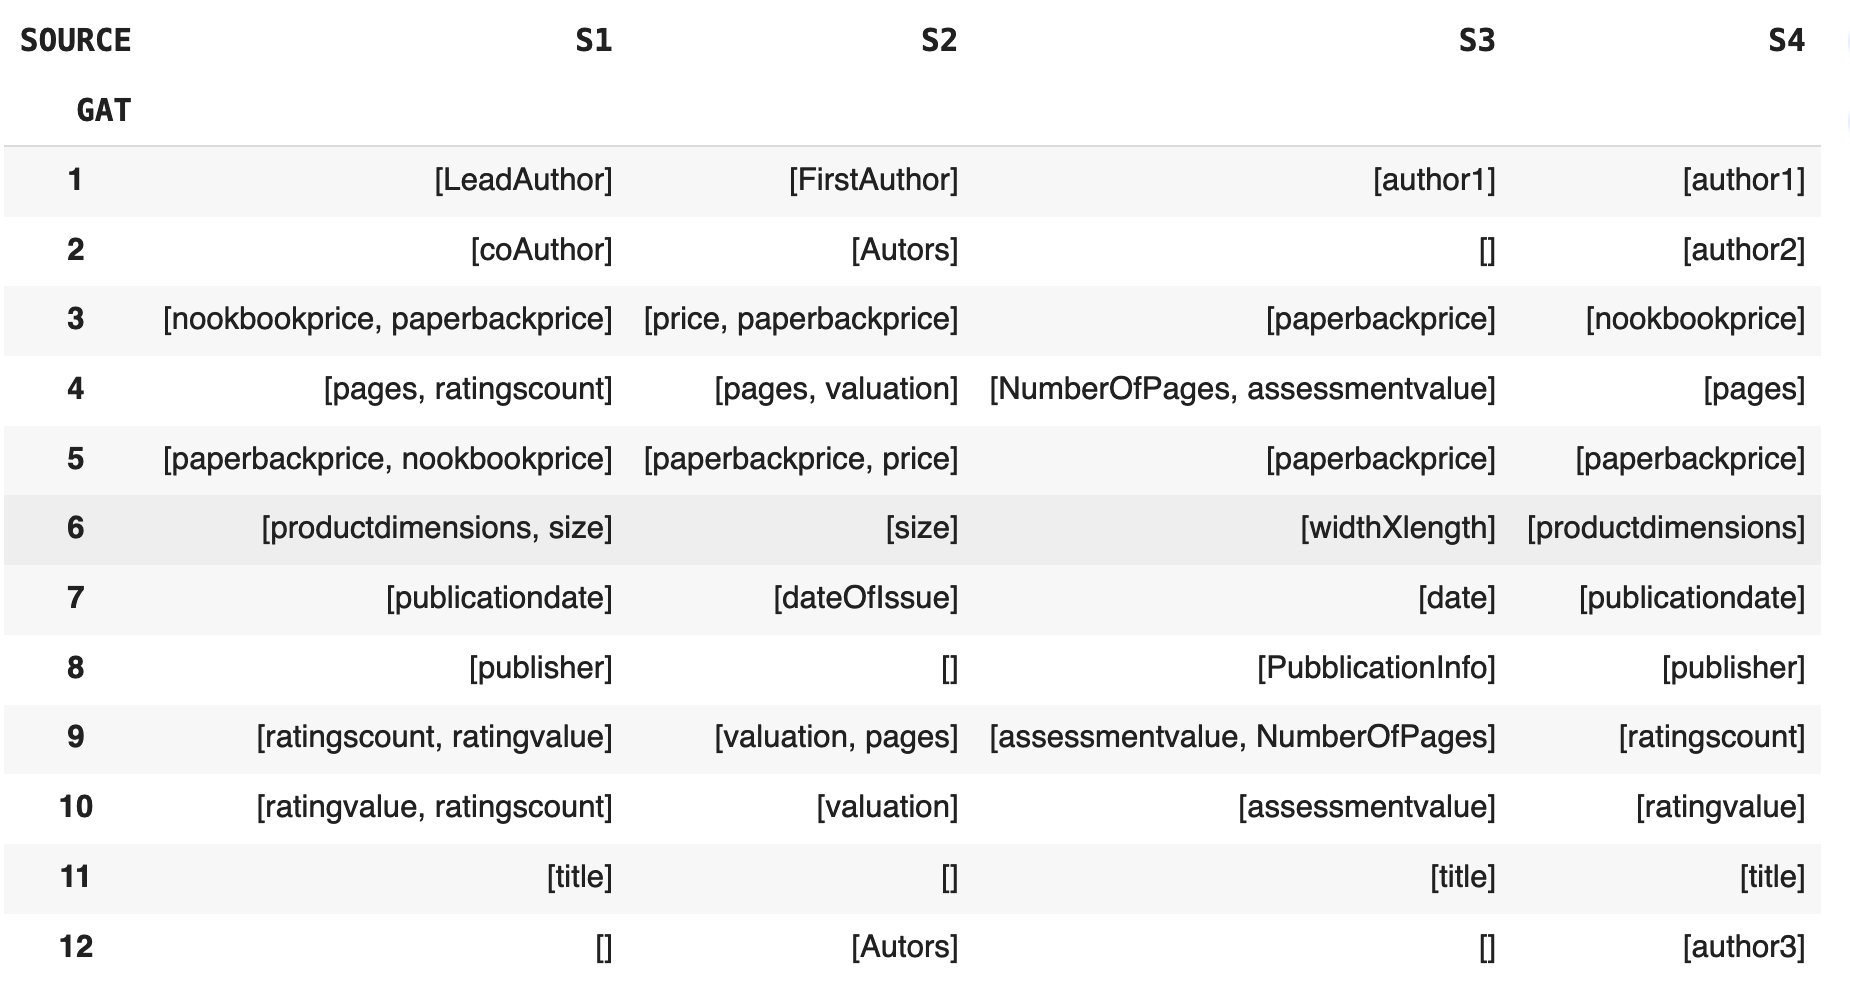

In [ ]:
GMT=to_GMT(SchemaIntegration(SOURCES))

S1 S1 12 -- S1 S2 10 -- S1 S3 6 -- S1 S4 11 -- S2 S2 10 -- S2 S3 8 -- S2 S4 9 -- S3 S3 8 -- S3 S4 8 -- S4 S4 13 -- 

In [ ]:
LAT=generaLAT(SOURCES)
NEW_GS=fix_goldstandard(GMT_GS)
GMT=to_GMT(SchemaIntegration(SOURCES))
to_GMM(GMT)

S1 S1 12 -- S1 S2 10 -- S1 S3 6 -- S1 S4 11 -- S2 S2 10 -- S2 S3 8 -- S2 S4 9 -- S3 S3 8 -- S3 S4 8 -- S4 S4 13 -- 

SOURCE,S1,S2,S3,S4
GAT,,,,
1,"[coAuthor, LeadAuthor]","[Autors, FirstAuthor]",[author1],"[author1, author2]"
2,[nookbookprice],[price],[],[nookbookprice]
3,[pages],[pages],[NumberOfPages],[pages]
4,[paperbackprice],[paperbackprice],[paperbackprice],[paperbackprice]
5,"[productdimensions, size]",[size],[widthXlength],[productdimensions]
6,[publicationdate],"[dateOfIssue, YearEditor]","[PubblicationInfo, date]",[publicationdate]
7,[publisher],[],[],[publisher]
8,[ratingscount],[valuation],[],[ratingscount]
9,[ratingvalue],[],[assessmentvalue],[ratingvalue]


In [ ]:
Valuta(MatchIndottiGMT(NEW_GS[['GAT', 'SLAT']]),MatchIndottiGMT(GMT[['GAT', 'SLAT']]))

,MT,TP,FP,FN,P,R,F
0,74,50,24,38,0.6757,0.5682,0.6173


# **Seconda prova con BabelNet**


In [ ]:
#Abbiamo le nostre fonti
SOURCES={}
SOURCES['S1']=pd.read_csv('https://dbgroup.ing.unimore.it/SIWS/E1/S1.csv').astype(str)
SOURCES['S2']=pd.read_csv('https://dbgroup.ing.unimore.it/SIWS/E1/S2.csv').astype(str)
SOURCES['S3']=pd.read_csv('https://dbgroup.ing.unimore.it/SIWS/E1/S3.csv').astype(str)

LAT = pd.DataFrame(columns=['SOURCE', 'LAT', 'SLAT'])
for x in SOURCES.keys():
    for y in SOURCES[x].columns:
      LAT.loc[len(LAT)]=[str(x),str(y), str(x)+'_'+str(y)]



S1_annotations = {
          'Age1': {'lemma':'age','language': 'EN'},
          'Age2': {'lemma':'age','language': 'EN'},
          'Name':{'language': 'EN'},
          'Surname':{'language':'EN'},
          'City': {'language': 'EN'},
          'Phone2': {'lemma':'phone','language': 'EN'},
          'Phone3': {'lemma':'phone','language': 'EN'},
          'Phone4': {'lemma':'phone','language': 'EN'},
          'rec_id': {'lemma':'id','language': 'EN'},
          'X1':{'synset':'bn:00019319n'},
          'X2':{'lemma':'sex'}
    }

S2_annotations = {
          'Age1': {'lemma':'age','language': 'EN'},
          'Full Name':{'language':'EN'},
          'City2': {'lemma':'city','language': 'EN'},
          'City3': {'lemma':'city','language': 'EN'},
          'Phone1': {'lemma':'phone','language': 'EN'},
          'rec_id': {'lemma':'id','language': 'EN'}
}

S3_annotations = {
          'Age2': {'lemma':'age','language': 'EN'},
          'Age4': {'lemma':'age','language': 'EN'},
          'City1': {'language': 'EN'},
          'Phone1': {'lemma':'phone','language': 'EN'},
          'Full Name':{'language':'EN'},
          'Phone3': {'lemma':'phone','language': 'EN'},
          'Phone4': {'lemma':'phone','language': 'EN'},
          'City3': {'lemma':'city','language': 'EN'},
          'City2': {'lemma':'city','language': 'EN'},
          'rec_id': {'lemma':'id','language': 'EN'}
}

SOURCES['S1']=add_column_annotations(SOURCES['S1'],S1_annotations)
SOURCES['S2']=add_column_annotations(SOURCES['S2'],S2_annotations)
SOURCES['S3']=add_column_annotations(SOURCES['S3'],S3_annotations)

build_graph_dictionary(SOURCES)

Index(['rec_id', 'Name1', 'Name2', 'City1', 'Phone2', 'Phone3', 'Phone4',
       'Age1', 'Age2', 'Sex', 'gender2', 'X1', 'X2'],
      dtype='object')
risposta dell'API
[{'id': 'bn:21705944n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:10838275n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:22603542n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:27498588n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:02996921n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:07861292n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:00029223n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:01186797n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:13864097n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:00037612n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:00045826n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:03602805n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:00045822n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:04707104n', 'pos': 'NOUN', 

In [ ]:
SOURCES['S2'].head()

,rec_id,Nome Completo,City2,Phone1,Age1,Age3,City3,Sex,Sex2,gender,gender2,X1,X3
0,rec-35-org,jacob reid,newark,03 0373 8067,50,33,newark,m,28435.25,female,widowed,melbourne,126.075
1,rec-36-org,lexie lowe,newark,04 6936 7343,85,31,chicago,f,101028.87,female,single,sydney,112.181
2,rec-37-org,yasmin coleman,newark,03 9156 4619,87,27,newark,f,170319.486,female,married_spouce_present,sydney,112.405
3,rec-38-org,garth newey,newark,07 4065 7131,51,23,newark,m,87334.245,female,divorced,sydney,163.461
4,rec-39-org,catherine van der vlies,newark,02 7954 5346,63,34,houston,m,68747.00200000001,male,married_spouce_present,melbourne,110.565


In [ ]:
#noi dobbiamo solo cambiare il metodo CalcoloMatchingTable
#e capire come includere le sources e le annotazioni


#Difeniamo la funzione per la matching Table
def CalcoloMatchingTable(TableL:pd.DataFrame,TableR:pd.DataFrame):
        #SimTableA = levenshtein_label_based_similarity(TableL, TableR)
        SimTableA = value_overlap_extended_jaccard_LEV(TableL, TableR,0.55)
        #SimTableB = jaro_label_based_similarity(TableL, TableR)
        SimTableB = babelnet_label_based_similarity(TableL,TableR)
        #SimTableB = value_overlap_sim(GlobalSchema, Sources[y])
        SimTableC=  value_overlap_simjoin_jaccard(TableL, TableR, 0.55)

        # combiner
        #SimTable = avg_sim_table([SimTableA,SimTableB,SimTableC])
        # SimTable = min_sim_table([SimTableA,SimTableB,SimTableC])
        #SimTable = max_sim_table([SimTableA,SimTableB,SimTableC])

        # Weighted-sum
        SimTable = Weighted_sum([SimTableA,SimTableB,SimTableC], [0.3,0.3,0.4] )

        # dalla tabella di similarità alle corrispondenze

        MatchTable= thresholding(SimTable, 0.40)

        #MatchTable = top_K(SimTable,'A',2)
        MatchTable = top_1(MatchTable,'A')

         # global mapping
        #MatchTable = stable_marriage(MatchTable)
        #MatchTable = simmetric_best_match(MatchTable)
        return MatchTable

In [ ]:
#Carichiamo il gold standard
GoldStandard=pd.read_csv("https://dbgroup.ing.unimore.it/SIWS/E1/GoldStandardEsempioE1.csv").astype(str)
#to_GMM(GoldStandard)
GoldStandard

,GAT,SOURCE,LAT,SLAT
0,rec_id,S1,rec_id,S1_rec_id
1,rec_id,S2,rec_id,S2_rec_id
2,rec_id,S3,rec_id,S3_rec_id
3,Name,S1,Name,S1_Name1
4,Name,S2,Full Name,S2_Nome Completo
5,Name,S3,Full Name,S3_Nome Completo
6,Surname,S1,Surname,S1_Name2
7,Surname,S2,Full Name,S2_Nome Completo
8,Surname,S3,Full Name,S3_Nome Completo
9,Main Work Address (City),S1,City,S1_City1


In [ ]:
#Otteniamo la GMM facendo il clustering
GMM=SchemaIntegration(SOURCES)
GMM

il nodo Name1 non c'è!
il nodo Name2 non c'è!
il nodo City1 non c'è!
il nodo gender2 non c'è!
il nodo Name1 non c'è!
il nodo Name2 non c'è!
il nodo City1 non c'è!
il nodo gender2 non c'è!
il nodo Name1 non c'è!
il nodo Name2 non c'è!
il nodo City1 non c'è!
il nodo gender2 non c'è!
il nodo Name1 non c'è!
il nodo Name2 non c'è!
il nodo City1 non c'è!
il nodo gender2 non c'è!
il nodo Name1 non c'è!
il nodo Name2 non c'è!
il nodo City1 non c'è!
il nodo gender2 non c'è!
il nodo Name1 non c'è!
il nodo Name2 non c'è!
il nodo City1 non c'è!
il nodo gender2 non c'è!
il nodo Name1 non c'è!
il nodo Name2 non c'è!
il nodo City1 non c'è!
il nodo gender2 non c'è!
il nodo Name1 non c'è!
il nodo Name2 non c'è!
il nodo City1 non c'è!
il nodo gender2 non c'è!
il nodo Name1 non c'è!
il nodo Name2 non c'è!
il nodo City1 non c'è!
il nodo gender2 non c'è!
S1 S1 13 -- il nodo Nome Completo non c'è!
il nodo Age3 non c'è!
il nodo Sex2 non c'è!
il nodo gender2 non c'è!
il nodo X3 non c'è!
il nodo Nome Completo 

SOURCE,S1,S2,S3
GAT,,,
1,"[Age1, Age2]",[Age1],[Age2]
2,[City1],[],[]
3,[Name1],[],[]
4,[Name2],[],[]
5,[Phone2],[],[]
6,[Phone3],[],[]
7,[Phone4],[],[]
8,"[Sex, X2]",[Sex],[]
9,[X1],[X1],[X1]


In [ ]:
# dataframe per memorizzare le valutazioni dei vari metodi
ValutazioneMatchTable = pd.DataFrame(columns=['MT', 'TP', 'FP', 'FN', 'P', 'R', 'F'])

In [ ]:
#Valutiamo il primo metodo
#Mettiamo in una var così non scriviamo sul DF
Valutazione=Valuta(MatchIndottiGMT(GoldStandard), MatchIndottiGMT(to_GMT(GMM)))
Valutazione

,MT,TP,FP,FN,P,R,F
0,22,8,14,14,0.3636,0.3636,0.3636


In [ ]:
#append della nuova valutazione
ValutazioneMatchTable = ValutazioneMatchTable.append(
    Valutazione).rename(index={0: 'ProvaConAvg_06'})
ValutazioneMatchTable

,MT,TP,FP,FN,P,R,F
ProvaConAvg_06,29,8,21,14,0.2759,0.3636,0.3137


#**Experiment with BabelNet**

In [ ]:
#This case is a step by step demonstration of the Usability of the BabelNet

we setup the languages targets of our analysis

In [ ]:
languages=['EN','MUL']
#MUL stands for multilingual, sometimes BabelNet puts esential edges as MUL language

In [ ]:
V = nx.Graph() #graph initialization

In [ ]:
#Person(Appellation, Address)
#Individual(Name, Location)

#We define dictionary where to put our dataframes
SOURCES={}

#Empty dataframes since the matching will be esentially label based only
df_person = pd.DataFrame({
    'Appelation': [],
    'Address': [],
})
df_individual = pd.DataFrame({
    'Name': [],
    'Location': [],
})

#additions
SOURCES['S1']=df_person.astype(str)
SOURCES['S2']=df_individual.astype(str)

In [ ]:
#we build the graph by passing the dictionary of our dataframes
build_graph_dictionary(SOURCES)

Index(['Appelation', 'Address'], dtype='object')
risposta dell'API
[{'id': 'bn:00005032n', 'pos': 'NOUN', 'source': 'BABELNET'}]
risposta dell'API
[{'id': 'bn:14580377n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:00001308n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:00001302n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:00001306n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:00001304n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:00082338v', 'pos': 'VERB', 'source': 'BABELNET'}, {'id': 'bn:00082229v', 'pos': 'VERB', 'source': 'BABELNET'}, {'id': 'bn:00082334v', 'pos': 'VERB', 'source': 'BABELNET'}, {'id': 'bn:00082336v', 'pos': 'VERB', 'source': 'BABELNET'}, {'id': 'bn:17477343n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:00001309n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:00001307n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:00082340v', 'pos': 'VERB', 'source': 'BABELNET'}, {'id': 'bn:00082332v', 'pos': 'VERB', 'source': 'BABELNET'}

In [ ]:
#our matches
babelnet_label_based_similarity(SOURCES['S1'],SOURCES['S2'])

,A,B,sim
0,Appelation,Name,0.8
1,Appelation,Location,0.0
2,Address,Name,0.8
3,Address,Location,0.0


In [ ]:
#now we try with the annotations
#Empty dataframes since the matching will be esentially label based only
df_person = pd.DataFrame({
    'Appelation': [],
    'Address': [],
})
df_individual = pd.DataFrame({
    'Name': [],
    'Location': [],
})

#additions
SOURCES['S1']=df_person.astype(str)
SOURCES['S2']=df_individual.astype(str)

In [ ]:
V = nx.Graph() #we reset the graph

In [ ]:
df_person_annotations = {
      'Address':  {'synset':'bn:00001303n'},
}

SOURCES['S1']=add_column_annotations(SOURCES['S1'],df_person_annotations)

df_individual_annotations = {
      'Location':  {'synset':'bn:00051760n'},
}

SOURCES['S2']=add_column_annotations(SOURCES['S2'],df_individual_annotations)

In [ ]:
build_graph_dictionary(SOURCES)

Index(['Appelation', 'Address'], dtype='object')
risposta dell'API
[{'id': 'bn:00005032n', 'pos': 'NOUN', 'source': 'BABELNET'}]
Index(['Name', 'Location'], dtype='object')
risposta dell'API
[{'id': 'bn:00064751n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:01454938n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:00037747n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:00056758n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:01765022n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:27426992n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:03508754n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:24176884n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:00034390n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:00045822n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:00086766v', 'pos': 'VERB', 'source': 'BABELNET'}, {'id': 'bn:00086663v', 'pos': 'VERB', 'source': 'BABELNET'}, {'id': 'bn:07958411n', 'pos': 'NOUN', 'source': 'BABELNET'}, {'id': 'bn:0008

In [ ]:
babelnet_label_based_similarity(SOURCES['S1'],SOURCES['S2'])

,A,B,sim
0,Appelation,Name,0.8
1,Appelation,Location,0.0
2,Address,Name,0.0
3,Address,Location,0.0


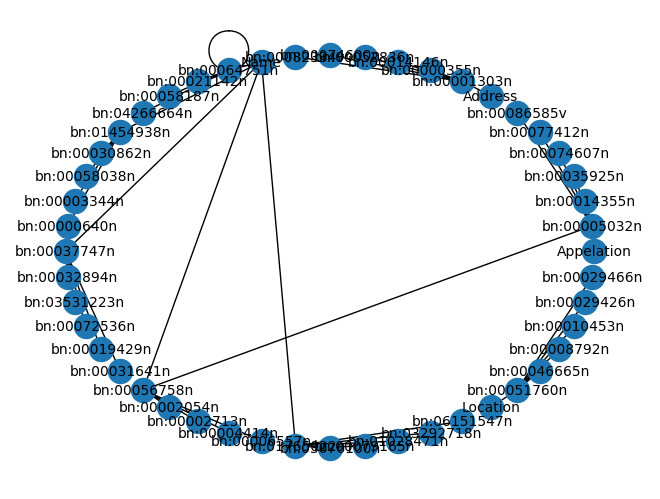

In [ ]:
pos = nx.circular_layout(V)
nx.draw(V, pos, with_labels=True, font_size=10)

# **Graph building example**

In [ ]:
df_individual = pd.DataFrame({
    'Name': [],
    'Location': [],
})
df_individual_annotations = {
      'Name':{'synset':'bn:00056758n'},
      'Location':  {'synset':'bn:00051760n'},
}
SOURCES={}
#additions
SOURCES['S1']=df_individual.astype(str)
SOURCES['S1']=add_column_annotations(SOURCES['S1'],df_individual_annotations)
build_graph_dictionary(SOURCES)

Index(['Name', 'Location'], dtype='object')


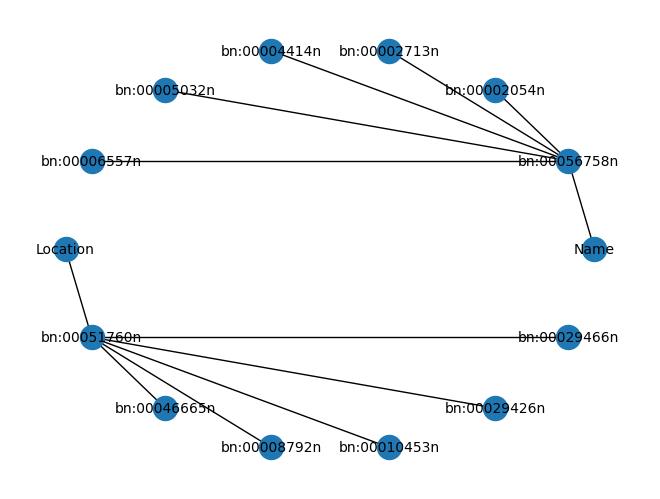

In [ ]:
pos = nx.circular_layout(V)
nx.draw(V, pos, with_labels=True, font_size=10)